In [6]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import tensorflow as tf
from datetime import datetime, timedelta
import wandb
from wandb.keras import WandbCallback
import graphviz

In [7]:
wandb.init(project="NFT-prediction")


Traceback (most recent call last):
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\wandb\sdk\wandb_init.py", line 1075, in init
    wi.setup(kwargs)
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\wandb\sdk\wandb_init.py", line 165, in setup
    self._wl = wandb_setup.setup()
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\wandb\sdk\wandb_setup.py", line 312, in setup
    ret = _setup(settings=settings)
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\wandb\sdk\wandb_setup.py", line 307, in _setup
    wl = _WandbSetup(settings=settings)
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\wandb\sdk\wandb_setup.py", line 293, in __init__
    _WandbSetup._instance = _WandbSetup__WandbSetup(settings=settings, pid=pid)
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\wandb\sdk\wandb_setup.py", line 100, in __init__
    self._settings = self._settings_setup(settings, self._early_logger)
  File "C:\Users\aitbudapest\anaconda3\lib\site-packages\w

Exception: problem

In [31]:
wandb.config = {
  "learning_rate": 0.01,
  "epochs": 25,
  "batch_size": 32
}

In [1]:
f = open("../data/prediction.csv", 'r')
pred = pd.read_csv(f)
del pred['Unnamed: 0']
pred["Date"] = pd.to_datetime(pred['Date'], format='%Y-%m-%d')
pred = pred.astype({'Number_of_sales':'float32','Active_markets_wallets':'float32','Primary_sales':'float32','ETH_high_price':'float32'})
pred = pred.set_index("Date")
pred.head()


NameError: name 'pd' is not defined

In [5]:
#only predict one variable
#calculate accuracy based on that

In [33]:
pred = pred.replace('?', np.nan)
pred = pred.replace('null', np.nan)

def fill_missing(values):
    for row in range(pred.shape[0]):
        for col in range(pred.shape[1]):
            if (values[row][col] == np.nan):
                values[row,col] = values[row-1, col]
pred.isnull().sum()

Number_of_sales           0
Active_markets_wallets    0
Primary_sales             8
ETH_high_price            0
Sales_USD                 0
dtype: int64

In [34]:

fill_missing(pred.values)
pred.isnull().sum()
for i in range(pred.shape[0]):
    if (type(pred.iloc[i]["Active_markets_wallets"]) != np.float64):
        print(i)


In [36]:
#75% 25% split
# 1466*0.75 = 1099
train_df,test_df = pred[1:1099], pred[1099:] 
train = train_df
test = test_df
'''
from sklearn.preprocessing import MinMaxScaler
#min max
train = train_df
scalers={}
for i in train_df.columns:
    if (i == "Date"):
        #skip
        print("nothing")
    else:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        train[i]=s_s
test = test_df
for i in train_df.columns:
    if (i == "Date"):
        #skip
        print("nothing")
    else:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+i] = scaler
        test[i]=s_s
'''

'\nfrom sklearn.preprocessing import MinMaxScaler\n#min max\ntrain = train_df\nscalers={}\nfor i in train_df.columns:\n    if (i == "Date"):\n        #skip\n        print("nothing")\n    else:\n        scaler = MinMaxScaler(feature_range=(-1,1))\n        s_s = scaler.fit_transform(train[i].values.reshape(-1,1))\n        s_s=np.reshape(s_s,len(s_s))\n        scalers[\'scaler_\'+ i] = scaler\n        train[i]=s_s\ntest = test_df\nfor i in train_df.columns:\n    if (i == "Date"):\n        #skip\n        print("nothing")\n    else:\n        scaler = scalers[\'scaler_\'+i]\n        s_s = scaler.transform(test[i].values.reshape(-1,1))\n        s_s=np.reshape(s_s,len(s_s))\n        scalers[\'scaler_\'+i] = scaler\n        test[i]=s_s\n'

In [37]:
def split_series(df, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  series = df.values
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = df.iloc[window_start:past_end, 0:4], df.iloc[past_end:future_end, 4:]
    past = past.values
    future = future.values
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

#use 10 days to predict 5 days into the future
n_past = 10
n_future = 5 
n_features_train = 4
n_features_predict=1

In [38]:
temp = train.iloc[1:3, 4:]
print(temp)

             Sales_USD
Date                  
2017-11-11  319.453003
2017-11-12  319.153015


In [39]:
#split into samples 
X_train, y_train = split_series(train,n_past, n_future)
#print(X_train)
#print(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features_train))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features_predict))
X_test, y_test = split_series(test,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features_train))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features_predict))

In [40]:
#Now we will create two models in the below-mentioned architecture.
#E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features_train))
encoder_l1 = tf.keras.layers.LSTM(4, return_state=True)
#reduce to smaller number, dimensionality
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(4, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
#reduce dimensionality
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features_predict))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 4),          144         ['input_2[0][0]']                
                                 (None, 4),                                                       
                                 (None, 4)]                                                       
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 5, 4)        0           ['lstm_2[0][0]']                 
                                                                                            

In [41]:
#not going to use, worried about overfiting the model

#E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

# E2D2
# n_features ==> no of features at each timestep in the data.
#
'''
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()
'''

'\nencoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))\nencoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)\nencoder_outputs1 = encoder_l1(encoder_inputs)\nencoder_states1 = encoder_outputs1[1:]\nencoder_l2 = tf.keras.layers.LSTM(100, return_state=True)\nencoder_outputs2 = encoder_l2(encoder_outputs1[0])\nencoder_states2 = encoder_outputs2[1:]\n#\ndecoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])\n#\ndecoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)\ndecoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)\ndecoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)\n#\nmodel_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)\n#\nmodel_e2d2.summary()\n'

In [42]:
#one fit method don't do both
'''
history = model_e1d1.fit(X_train, # input data
                    y_train, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=10, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[WandbCallback()], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #callbacks=[WandbCallback()]
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=100, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )
                '''

'\nhistory = model_e1d1.fit(X_train, # input data\n                    y_train, # target data\n                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.\n                    epochs=10, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided\n                    verbose=1, # default=\'auto\', (\'auto\', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. \'auto\' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.\n                    callbacks=[WandbCallback()], # default=None, list of callbacks to apply during training. See tf.keras.callbacks\n                    #callbacks=[WandbCallback()]\n                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the 

In [43]:
#fit data other attempt with different metrics
#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
#model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
model_e1d1.compile(
    optimizer='adam',
    loss=tf.keras.losses.Huber(),
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
    ]
)
#no validation data so i can test accuracy
#history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,batch_size=32,verbose=0,callbacks=[WandbCallback()])
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[WandbCallback()])
#model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
'''
model_e2d2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.Accuracy(),
        tf.keras.metrics.MeanAbsoluteError(),
    ]
)
'''
#history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[WandbCallback()])

"\nmodel_e2d2.compile(\n    optimizer='adam',\n    loss='mean_squared_error',\n    metrics=[\n        tf.keras.metrics.MeanSquaredError(),\n        tf.keras.metrics.Accuracy(),\n        tf.keras.metrics.MeanAbsoluteError(),\n    ]\n)\n"

In [44]:
##### Step 6 - Use model to make predictions
# Predict results on training data
pred_e1d1 = model_e1d1.predict(X_test)
print(pred_e1d1)
print(y_test)

12/12 [==============================] - 1s 3ms/step
[[[3.8793116]
  [7.1417665]
  [8.448098 ]
  [8.668506 ]
  [8.700203 ]]

 [[3.8793116]
  [7.1417665]
  [8.448098 ]
  [8.668506 ]
  [8.700203 ]]

 [[3.8793116]
  [7.1417665]
  [8.448098 ]
  [8.668506 ]
  [8.700203 ]]

 ...

 [[      nan]
  [      nan]
  [      nan]
  [      nan]
  [      nan]]

 [[      nan]
  [      nan]
  [      nan]
  [      nan]
  [      nan]]

 [[      nan]
  [      nan]
  [      nan]
  [      nan]
  [      nan]]]
[[[ 550.227417]
  [ 579.372498]
  [ 609.98761 ]
  [ 621.173401]
  [ 605.094177]]

 [[ 579.372498]
  [ 609.98761 ]
  [ 621.173401]
  [ 605.094177]
  [ 575.641479]]

 [[ 609.98761 ]
  [ 621.173401]
  [ 605.094177]
  [ 575.641479]
  [ 530.777161]]

 ...

 [[4530.99707 ]
  [4640.921875]
  [4822.363281]
  [4837.589355]
  [4859.50293 ]]

 [[4640.921875]
  [4822.363281]
  [4837.589355]
  [4859.50293 ]
  [4778.059082]]

 [[4822.363281]
  [4837.589355]
  [4859.50293 ]
  [4778.059082]
  [4808.73877 ]]]


In [50]:
#compare the pred_e1d1 and y_test
#print(y_test.shape)

def find_error(real, predicted):
    for i in range(5):
        return (abs(predicted[i]-real[i])/real[i])

count=0
sum=0
for i in range(348):
    acc = find_error(y_test[i].flatten().tolist(),pred_e1d1[i].flatten().tolist())
    #print(acc)
    sum += acc
    count += 5

print("Total error sum: " + str(sum))
print("Total count of predicted values: " + str(count))
print("Mean percent error: " + str(sum/count))

Total error sum: 347.2191431093455
Total count of predicted values: 1740
Mean percent error: 0.19955123167203764


In [46]:
#slicing the tensor to avoid the nan
t3 = tf.constant([[[1, 3, 5, 7],
                   [9, 11, 13, 15]],
                  [[17, 19, 21, 23],
                   [25, 27, 29, 31]]
                  ])
print(t3.shape)

print(tf.slice(t3,
               begin=[1, 1, 0],
               size=[1, 1, 2]))
print(X_test.shape)

print(tf.slice(X_test, begin=[0,0,0],size=[348,10,4]))

(2, 2, 4)
tf.Tensor([[[25 27]]], shape=(1, 1, 2), dtype=int32)
(353, 10, 4)
tf.Tensor(
[[[3.9045862e+05 3.0800000e+03 3.2400000e+02 1.8410000e+03]
  [1.0079416e+06 1.6955000e+04 2.8700000e+02 1.5316000e+04]
  [4.5275247e+05 3.3660000e+03 2.2700000e+02 1.5120000e+03]
  ...
  [3.1234050e+05 2.5590000e+03 4.7200000e+02 1.1740000e+03]
  [3.6883125e+05 3.0430000e+03 1.8800000e+02 1.6240000e+03]
  [2.7230009e+05 2.3700000e+03 1.6800000e+02 1.2580000e+03]]

 [[1.0079416e+06 1.6955000e+04 2.8700000e+02 1.5316000e+04]
  [4.5275247e+05 3.3660000e+03 2.2700000e+02 1.5120000e+03]
  [4.4918834e+05 4.1500000e+03 3.6500000e+02 2.3450000e+03]
  ...
  [3.6883125e+05 3.0430000e+03 1.8800000e+02 1.6240000e+03]
  [2.7230009e+05 2.3700000e+03 1.6800000e+02 1.2580000e+03]
  [6.5216988e+05 2.4580000e+03 1.5600000e+02 1.4150000e+03]]

 [[4.5275247e+05 3.3660000e+03 2.2700000e+02 1.5120000e+03]
  [4.4918834e+05 4.1500000e+03 3.6500000e+02 2.3450000e+03]
  [3.7104938e+05 3.8200000e+03 3.3800000e+02 1.9620000e+0

In [47]:
#evaluate
print(X_test.shape)
results = model_e1d1.evaluate(tf.slice(X_test, begin=[0,0,0],size=[348,10,4]), tf.slice(y_test, begin=[0,0,0],size=[348,5,1]), batch_size=128)
print("test loss, test acc:", results)

(353, 10, 4)
3/3 [==============================] - 1s 4ms/step - loss: 2375.8560 - mean_squared_error: 6762150.0000 - mean_absolute_error: 2376.3560
test loss, test acc: [2375.85595703125, 6762150.0, 2376.35595703125]


In [48]:
# list all data in history
print(history_e1d1.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


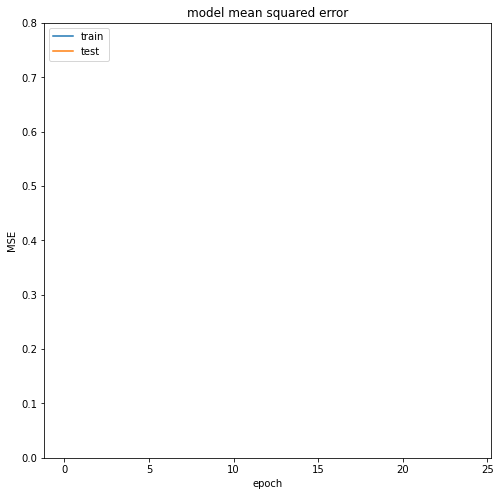

<Figure size 432x288 with 0 Axes>

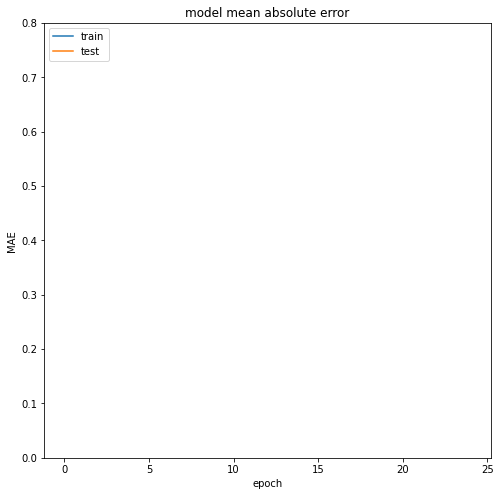

<Figure size 432x288 with 0 Axes>

In [49]:
# Visualize training history

# list all data in history
print(history_e1d1.history.keys())
# summarize history for MSE
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(history_e1d1.history['mean_squared_error'])
plt.plot(history_e1d1.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.ylim(0, 0.8)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('../visuals/model_e1d1_MSE_plot.png')
# summarize history for loss
'''
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''
# summarize history for MSE
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(history_e1d1.history['mean_absolute_error'])
plt.plot(history_e1d1.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.ylim(0, 0.8)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('../visuals/model_e1d1_MAE_plot.png')

# Graphing and visualization time
idk what these are telling us but don't they look fun?

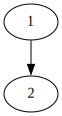

In [45]:
#run this to check that graphviz is working
from graphviz import Digraph

dot = Digraph()
dot.node('1')
dot.node('2')
dot.edges(['12'])
dot

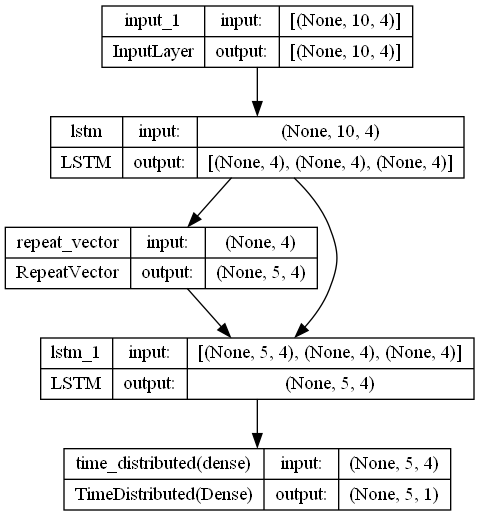

In [10]:
#graph model attempts
import pydot
from keras.utils.vis_utils import plot_model
import graphviz

plot_model(model_e1d1, to_file='../visuals/model_e1d1_plot.png', show_shapes=True, show_layer_names=True)

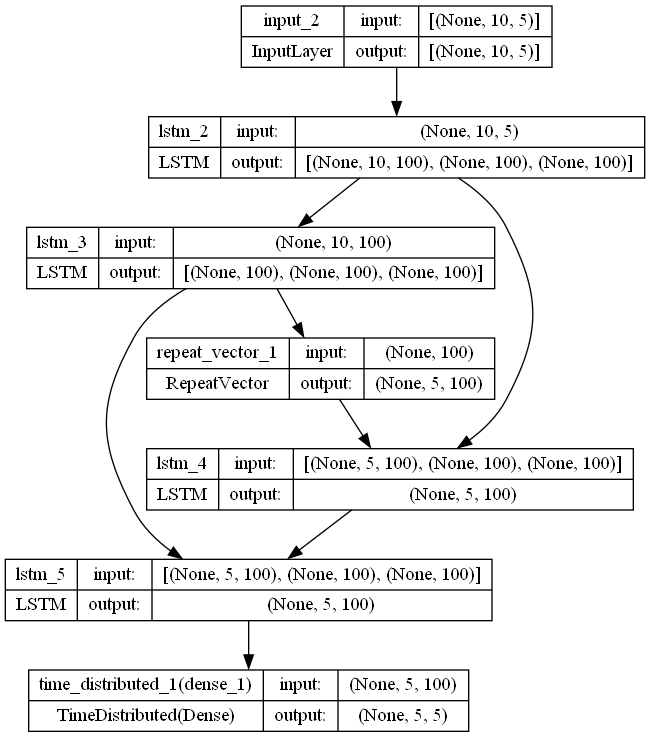

In [47]:
#plotting E2D2
plot_model(model_e2d2, to_file='../visuals/model_e2d2_plot.png', show_shapes=True, show_layer_names=True)